In [6]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
from modelling import plot_loss_accuracy_curves, evaluation_metrics

In [2]:
data_dir = "..\\..\\DATA\\HAM10000_images_part_1_and_2"  # directory with all images
dest_dir = "..\\..\\DATA\\recognized\\"  # directory where all images will be divided into subdirectories
df = pd.read_csv("..\\..\\DATA\\HAM10000_metadata")  # read metadata
df = df.rename(columns={"dx": "diagnosis"})
df = df[["image_id", "diagnosis"]]

In [3]:
# Load original data
X = []
y = []

for index, row in df.iterrows():
    img_path = os.path.join(data_dir, row['image_id'] + '.jpg')
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    X.append(img_array)
    y.append(row['diagnosis'])

In [4]:
X = np.array(X)
y = np.array(y)

In [5]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=7)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)  # split images into test and train directories

In [7]:
class_counts = np.sum(y_train, axis=0)

In [8]:
class_counts = class_counts.astype(int)

In [9]:
max_images_per_class = 1000

In [10]:
sampling_strategy = {i: min(count, max_images_per_class) for i, count in enumerate(class_counts)}

In [11]:
sampling_strategy

{0: 262, 1: 411, 2: 879, 3: 92, 4: 890, 5: 1000, 6: 114}

In [12]:
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)

In [13]:
X_train_over_sampled, y_train_over_sampled = rus.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

In [14]:
ros = RandomOverSampler()

In [15]:
X_train_balanced, y_train_balanced = ros.fit_resample(X_train_over_sampled, y_train_over_sampled)

In [16]:
X_train_balanced = X_train_balanced.reshape(-1, X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [17]:
class_names = label_encoder.classes_

In [18]:
class_names

array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype='<U5')

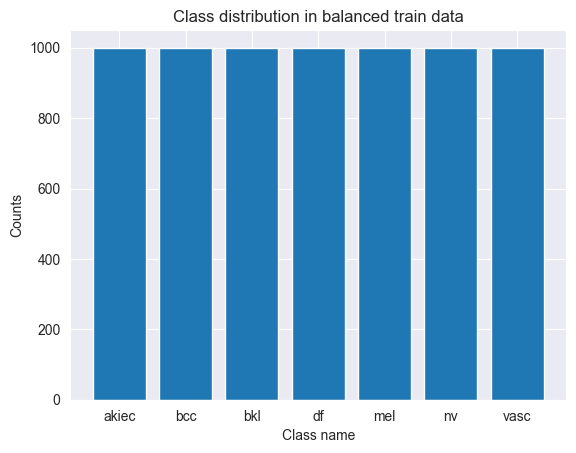

In [18]:
class_counts = np.sum(y_train_balanced, axis=0)
unique = np.unique(class_names)
plt.bar(x=class_names, height=class_counts)
plt.title("Class distribution in balanced train data")
plt.xlabel("Class name")
plt.ylabel("Counts");

In [19]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255.,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    vertical_flip=True,
    fill_mode="reflect"
)

test_datagen = ImageDataGenerator(rescale=1. / 255.)

In [20]:
len(X_train_balanced)

7000

In [21]:
train_data = train_datagen.flow(X_train_balanced, y_train_balanced, batch_size=32)
test_data = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

In [22]:
tf.random.set_seed(42)
model_1a = Sequential([
    Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(128, 128, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2, padding="valid"),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(2),
    Flatten(),
    Dense(128, activation="relu"),  
    Dense(7, activation="softmax")
])

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [25]:
model_1a.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history_1a = model_1a.fit(train_data, epochs=5,
                        validation_data = test_data)

Epoch 1/5


C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 45s 187ms/step - accuracy: 0.2457 - loss: 1.8236 - val_accuracy: 0.2926 - val_loss: 1.9771
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 170ms/step - accuracy: 0.4167 - loss: 1.4609 - val_accuracy: 0.5152 - val_loss: 1.1028
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 175ms/step - accuracy: 0.4847 - loss: 1.3307 - val_accuracy: 0.4134 - val_loss: 1.5689
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.4925 - loss: 1.2706 - val_accuracy: 0.5037 - val_loss: 1.1916
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 47s 209ms/step - accuracy: 0.5376 - loss: 1.1907 - val_accuracy: 0.5187 - val_loss: 1.1164


In [29]:
class_names = label_encoder.classes_

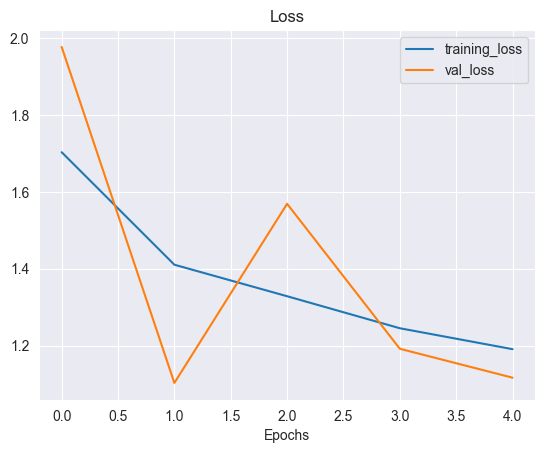

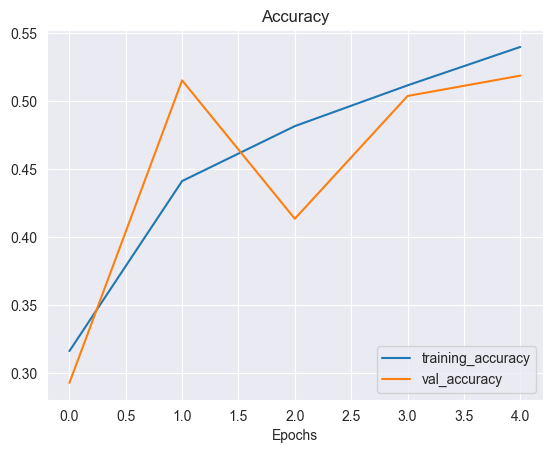

In [27]:
plot_loss_accuracy_curves(history_1a)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


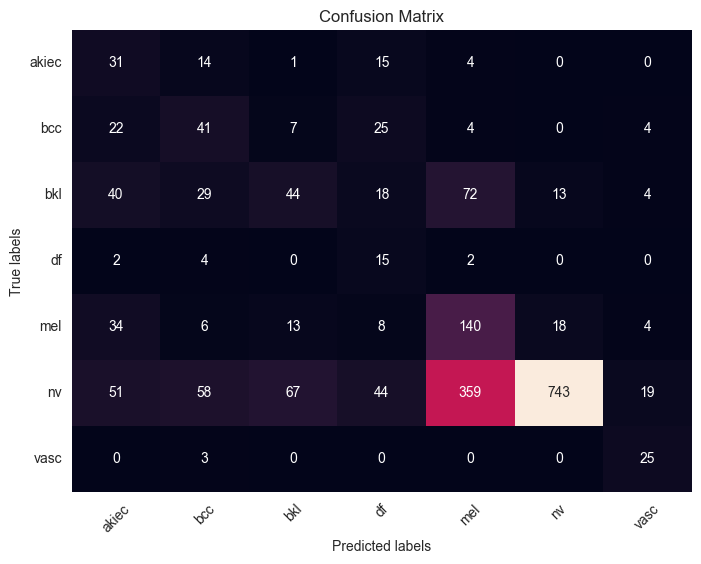

              precision    recall  f1-score   support

           0       0.17      0.48      0.25        65
           1       0.26      0.40      0.32       103
           2       0.33      0.20      0.25       220
           3       0.12      0.65      0.20        23
           4       0.24      0.63      0.35       223
           5       0.96      0.55      0.70      1341
           6       0.45      0.89      0.60        28

    accuracy                           0.52      2003
   macro avg       0.36      0.54      0.38      2003
weighted avg       0.73      0.52      0.57      2003


In [30]:
evaluation_metrics(model_1a, test_data, y_test, class_names)

In [45]:
model_2 = Sequential(
    [Conv2D(filters=32,
            kernel_size=3,
            activation="relu",
            input_shape=(128, 128, 3)),
     Conv2D(32,3,activation="relu"),
     MaxPool2D(pool_size=2, padding="valid"),
     Conv2D(64,3,activation="relu"),
     Conv2D(64,3,activation="relu"),
     MaxPool2D(2),
     Conv2D(128,3,activation="relu"),
     Conv2D(128,3, activation="relu"),
     MaxPool2D(2),
     Flatten(),
     Dense(128, activation="relu"),
     Dense(7, activation="softmax")
     ]
)

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [32]:
model_2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit(train_data, epochs=10,
                        validation_data=test_data)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 171s 764ms/step - accuracy: 0.1885 - loss: 1.8959 - val_accuracy: 0.4289 - val_loss: 1.4906
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 161s 732ms/step - accuracy: 0.2618 - loss: 1.7301 - val_accuracy: 0.5986 - val_loss: 1.2925
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 161s 735ms/step - accuracy: 0.2890 - loss: 1.6769 - val_accuracy: 0.6321 - val_loss: 1.0838
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 168s 763ms/step - accuracy: 0.3829 - loss: 1.4784 - val_accuracy: 0.2996 - val_loss: 1.5414
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 159s 724ms/step - accuracy: 0.4072 - loss: 1.3986 - val_accuracy: 0.5771 - val_loss: 1.2401
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 157s 714ms/step - accuracy: 0.4484 - loss: 1.3443 - val_accuracy: 0.4563 - val_loss: 1.2162
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 158s 718ms/step - accuracy: 0.4639 - loss: 1.2828 - val_accuracy: 0.4738 - val_loss: 1.2308
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 160s 726ms/step - accuracy: 0.4898 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step


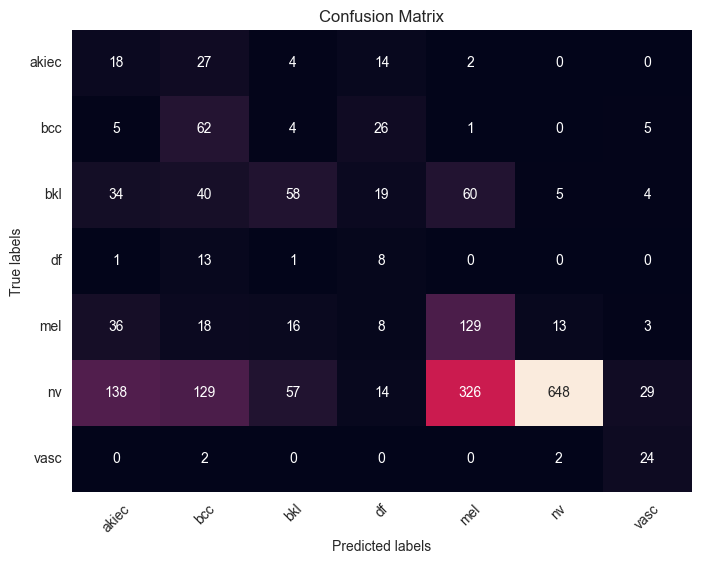

              precision    recall  f1-score   support

           0       0.08      0.28      0.12        65
           1       0.21      0.60      0.31       103
           2       0.41      0.26      0.32       220
           3       0.09      0.35      0.14        23
           4       0.25      0.58      0.35       223
           5       0.97      0.48      0.65      1341
           6       0.37      0.86      0.52        28

    accuracy                           0.47      2003
   macro avg       0.34      0.49      0.34      2003
weighted avg       0.74      0.47      0.54      2003


In [33]:
evaluation_metrics(model_2, test_data, y_test, class_names)

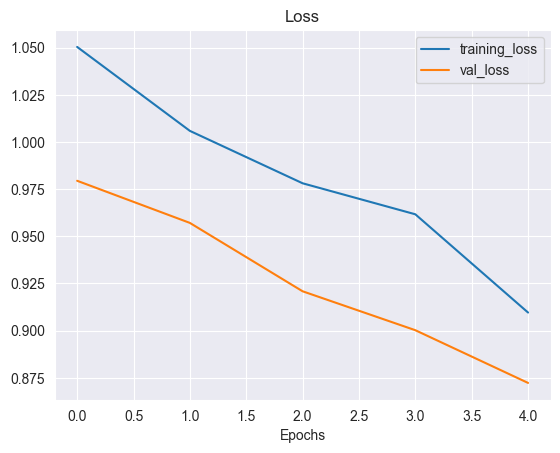

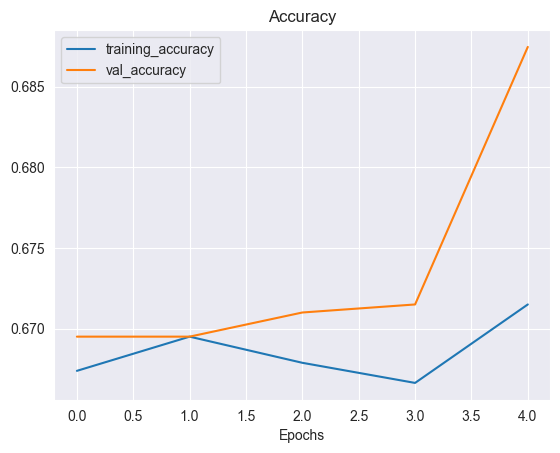

In [27]:
plot_loss_accuracy_curves(history_2)

In [34]:
model_1b = tf.keras.models.clone_model(model_1a)

In [35]:
model_1b.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_1b = model_1b.fit(train_data, epochs=20,
                        validation_data=test_data)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - accuracy: 0.2427 - loss: 1.8337 - val_accuracy: 0.4683 - val_loss: 1.3334
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.4324 - loss: 1.4605 - val_accuracy: 0.4134 - val_loss: 1.6326
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - accuracy: 0.4651 - loss: 1.3567 - val_accuracy: 0.5057 - val_loss: 1.1418
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 33s 150ms/step - accuracy: 0.5118 - loss: 1.2503 - val_accuracy: 0.5192 - val_loss: 1.0787
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - accuracy: 0.5242 - loss: 1.2340 - val_accuracy: 0.5761 - val_loss: 1.0348
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 33s 150ms/step - accuracy: 0.5352 - loss: 1.1953 - val_accuracy: 0.4743 - val_loss: 1.4104
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - accuracy: 0.5497 - loss: 1.1528 - val_accuracy: 0.4998 - val_loss: 1.2759
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - accuracy: 0.5717 - loss: 1

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


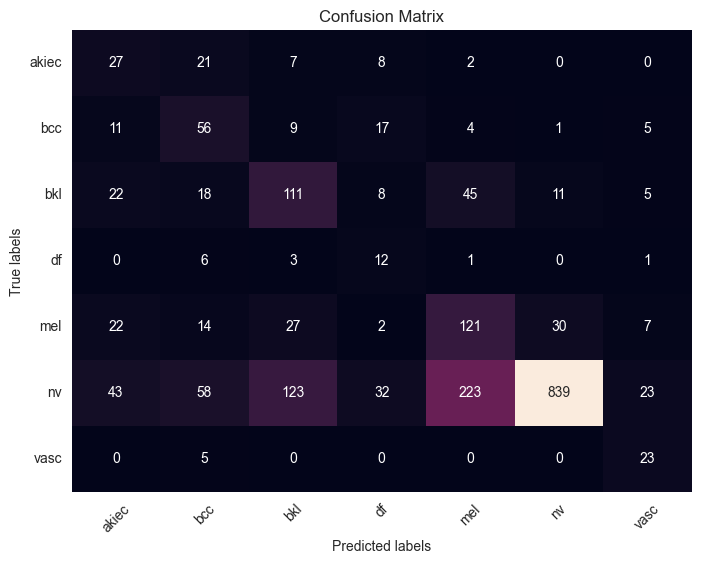

              precision    recall  f1-score   support

           0       0.22      0.42      0.28        65
           1       0.31      0.54      0.40       103
           2       0.40      0.50      0.44       220
           3       0.15      0.52      0.24        23
           4       0.31      0.54      0.39       223
           5       0.95      0.63      0.76      1341
           6       0.36      0.82      0.50        28

    accuracy                           0.59      2003
   macro avg       0.39      0.57      0.43      2003
weighted avg       0.75      0.59      0.64      2003


In [36]:
evaluation_metrics(model_1b, test_data, y_test, class_names)

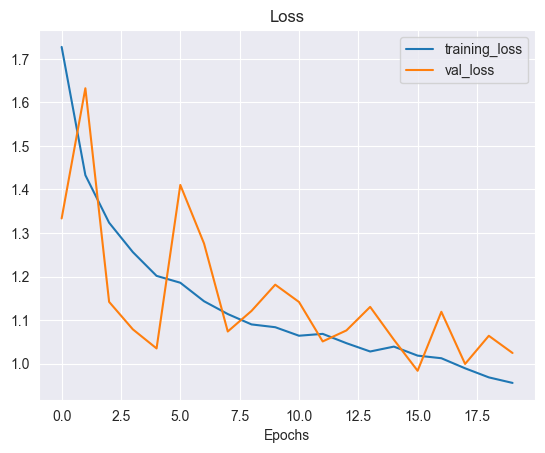

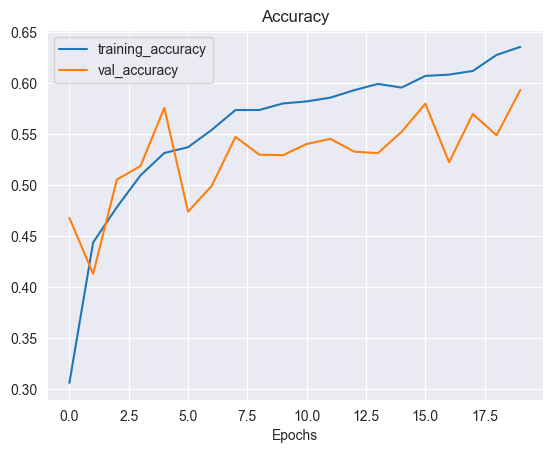

In [37]:
plot_loss_accuracy_curves(history_1b)

In [38]:
model_2b = Sequential(
    [BatchNormalization(),
     Conv2D(filters=32,
            kernel_size=3,
            activation="relu",
            input_shape=(128, 128, 3),
            padding="same"),
     Conv2D(32, 3, activation="relu", padding="same"),
     MaxPool2D(pool_size=2, padding="valid"),
     Conv2D(64, 3, activation="relu", padding="same"),
     Conv2D(64, 3, activation="relu", padding="same"),
     MaxPool2D(2),
     Conv2D(128, 3, activation="relu", padding="same"),
     Conv2D(128, 3, activation="relu", padding="same"),
     Conv2D(128, 3, activation="relu", padding="same"),
     MaxPool2D(2),
     Conv2D(256, 3, activation="relu", padding="same"),
     Conv2D(256, 3, activation="relu", padding="same"),
     Conv2D(256, 3, activation="relu", padding="same"),
     MaxPool2D(2),
     BatchNormalization(),
     Conv2D(512, 3, activation="relu", padding="same"),
     Conv2D(512, 3, activation="relu", padding="same"),
     Conv2D(512, 3, activation="relu", padding="same"),
     Flatten(),
     Dropout(0.3),
     Dense(1024, activation="relu"),
     Dropout(0.3),
     Dense(256, activation="relu"),
     Dense(7, activation="softmax")
     ]
)

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [39]:
model_2b.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_2b = model_2b.fit(train_data, epochs=10,
                        validation_data=test_data)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 525s 2s/step - accuracy: 0.1843 - loss: 2.0315 - val_accuracy: 0.0574 - val_loss: 2.5249
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 510s 2s/step - accuracy: 0.3294 - loss: 1.6350 - val_accuracy: 0.0669 - val_loss: 2.4402
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.3396 - loss: 1.5999 - val_accuracy: 0.0934 - val_loss: 2.6677
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 647s 3s/step - accuracy: 0.3575 - loss: 1.5666 - val_accuracy: 0.0699 - val_loss: 3.8607
Epoch 5/10
122/219 ━━━━━━━━━━━━━━━━━━━━ 3:54 2s/step - accuracy: 0.3776 - loss: 1.5083

KeyboardInterrupt: 

In [ ]:
evaluation_metrics(model_2b, train_data, y_test, class_names)

In [ ]:
plot_loss_accuracy_curves(history_2b)

In [52]:
model_1c = Sequential([
    Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(128, 128, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2, padding="valid"),
    Conv2D(32, 3, activation="relu"),
    Conv2D(32, 3, activation="relu"),
    MaxPool2D(2),
    Conv2D(64,3, activation="relu"),
    Conv2D(64,3, activation="relu"),
    Conv2D(64,3, activation="relu"),
    MaxPool2D(2),
    Flatten(),
    Dense(128, activation="relu"),  
    Dense(7, activation="softmax")
])

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [53]:
model_1c.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_1c = model_1c.fit(train_data, epochs=20,
                        validation_data=test_data)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 74s 313ms/step - accuracy: 0.1931 - loss: 1.8628 - val_accuracy: 0.2746 - val_loss: 1.7550
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 67s 297ms/step - accuracy: 0.3147 - loss: 1.6203 - val_accuracy: 0.5592 - val_loss: 1.2915
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 71s 317ms/step - accuracy: 0.3820 - loss: 1.4649 - val_accuracy: 0.5786 - val_loss: 1.1869
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 67s 301ms/step - accuracy: 0.4137 - loss: 1.3968 - val_accuracy: 0.4673 - val_loss: 1.2925
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 64s 282ms/step - accuracy: 0.4374 - loss: 1.3411 - val_accuracy: 0.5167 - val_loss: 1.1888
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 88s 399ms/step - accuracy: 0.4732 - loss: 1.2758 - val_accuracy: 0.5202 - val_loss: 1.2101
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 330ms/step - accuracy: 0.4662 - loss: 1.2853 - val_accuracy: 0.4668 - val_loss: 1.2193
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 78s 354ms/step - accuracy: 0.4909 - loss: 1

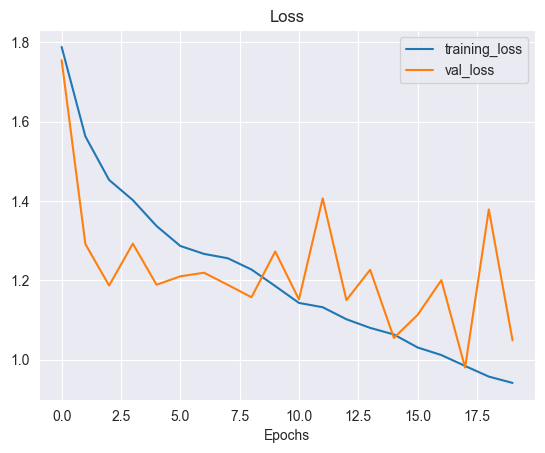

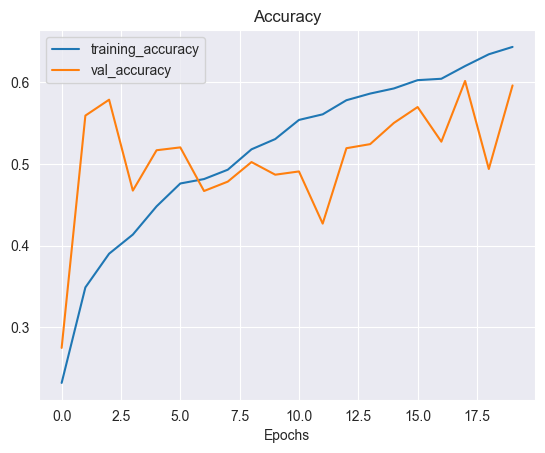

In [58]:
plot_loss_accuracy_curves(history_1c)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step


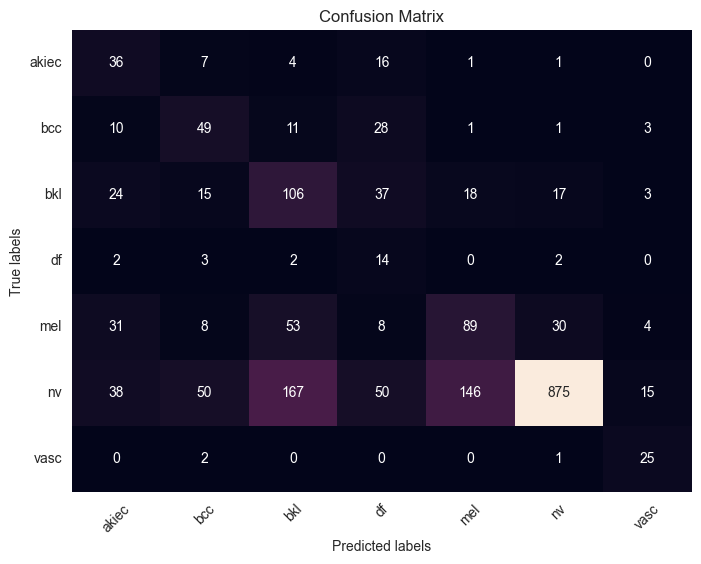

              precision    recall  f1-score   support

           0       0.26      0.55      0.35        65
           1       0.37      0.48      0.41       103
           2       0.31      0.48      0.38       220
           3       0.09      0.61      0.16        23
           4       0.35      0.40      0.37       223
           5       0.94      0.65      0.77      1341
           6       0.50      0.89      0.64        28

    accuracy                           0.60      2003
   macro avg       0.40      0.58      0.44      2003
weighted avg       0.74      0.60      0.64      2003


In [59]:
evaluation_metrics(model_1c, test_data, y_test, class_names)

In [56]:
model_1d = Sequential([
    Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(128, 128, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2, padding="valid"),
    Conv2D(32, 3, activation="relu"),
    Conv2D(32, 3, activation="relu"),
    MaxPool2D(2),
    Conv2D(64,3, activation="relu"),
    Conv2D(64,3, activation="relu"),
    Conv2D(64,3, activation="relu"),
    MaxPool2D(2),
    Flatten(),
    Dropout(0.5),
    Dense(64, activation="relu"),  
    Dense(7, activation="softmax")
])

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [57]:
model_1d.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_1d = model_1d.fit(train_data, epochs=20,
                        validation_data=test_data)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 94s 408ms/step - accuracy: 0.1909 - loss: 1.8861 - val_accuracy: 0.1078 - val_loss: 1.7289
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 79s 356ms/step - accuracy: 0.3086 - loss: 1.6388 - val_accuracy: 0.1588 - val_loss: 1.4055
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 86s 381ms/step - accuracy: 0.3637 - loss: 1.5361 - val_accuracy: 0.4643 - val_loss: 1.3290
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 76s 343ms/step - accuracy: 0.3967 - loss: 1.4280 - val_accuracy: 0.4458 - val_loss: 1.3349
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 74s 333ms/step - accuracy: 0.4392 - loss: 1.3691 - val_accuracy: 0.4478 - val_loss: 1.3060
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 95s 425ms/step - accuracy: 0.4388 - loss: 1.3615 - val_accuracy: 0.5197 - val_loss: 1.1020
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 91s 410ms/step - accuracy: 0.4704 - loss: 1.3218 - val_accuracy: 0.4918 - val_loss: 1.2348
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 84s 379ms/step - accuracy: 0.4822 - loss: 1

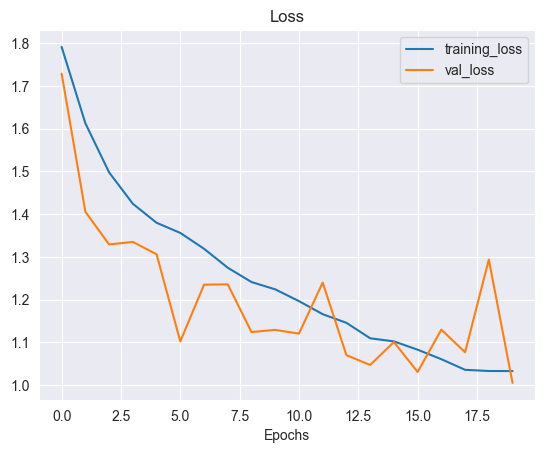

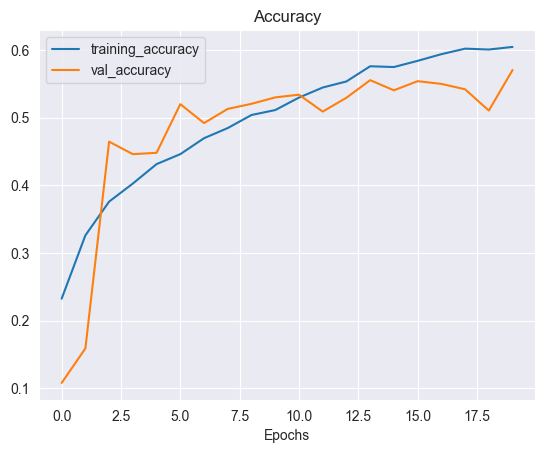

In [61]:
plot_loss_accuracy_curves(history_1d)

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step


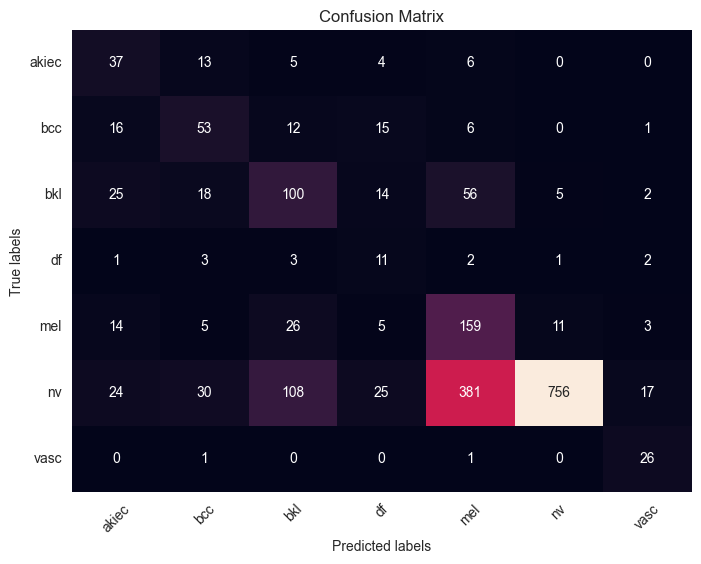

              precision    recall  f1-score   support

           0       0.32      0.57      0.41        65
           1       0.43      0.51      0.47       103
           2       0.39      0.45      0.42       220
           3       0.15      0.48      0.23        23
           4       0.26      0.71      0.38       223
           5       0.98      0.56      0.72      1341
           6       0.51      0.93      0.66        28

    accuracy                           0.57      2003
   macro avg       0.43      0.60      0.47      2003
weighted avg       0.77      0.57      0.62      2003


In [62]:
evaluation_metrics(model_1d, test_data, y_test, class_names)

In [63]:
model_1e = Sequential([
    Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(128, 128, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2, padding="valid"),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(2),
    Conv2D(10,3,activation="relu"),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(2),
    Flatten(),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),  
    Dense(7, activation="softmax")
])

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [64]:
model_1e.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_1e = model_1e.fit(train_data, epochs=100,
                        validation_data=test_data)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 51s 198ms/step - accuracy: 0.1597 - loss: 1.9364 - val_accuracy: 0.0664 - val_loss: 1.9579
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.2414 - loss: 1.7883 - val_accuracy: 0.5557 - val_loss: 1.5210
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 158ms/step - accuracy: 0.3673 - loss: 1.4892 - val_accuracy: 0.5127 - val_loss: 1.2676
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.4237 - loss: 1.3830 - val_accuracy: 0.5966 - val_loss: 1.0456
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 158ms/step - accuracy: 0.4518 - loss: 1.3301 - val_accuracy: 0.5696 - val_loss: 1.0701
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - accuracy: 0.4654 - loss: 1.2907 - val_accuracy: 0.5002 - val_loss: 1.2376
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 44s 199ms/step - accuracy: 0.4790 - loss: 1.2867 - val_accuracy: 0.5037 - val_loss: 1.2447
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - accuracy: 0.4991 -

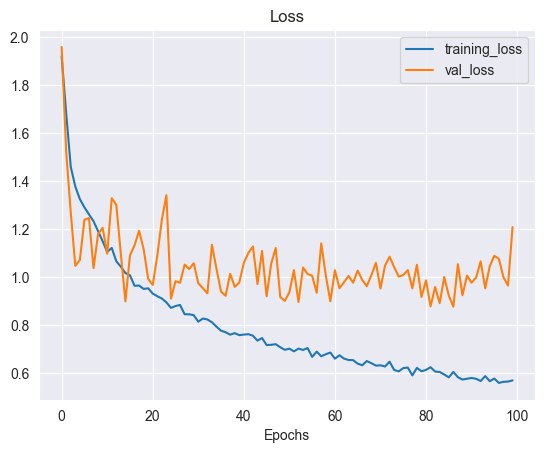

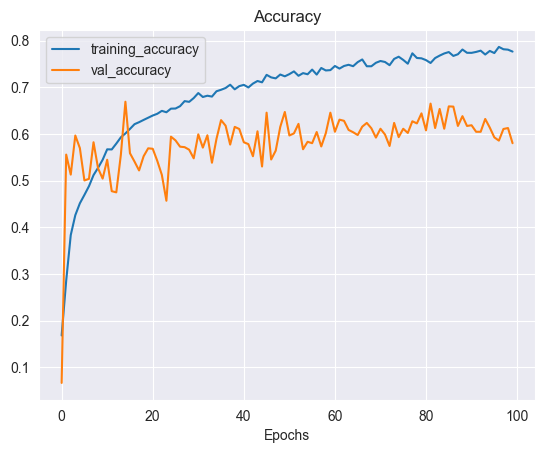

In [67]:
plot_loss_accuracy_curves(history_1e)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


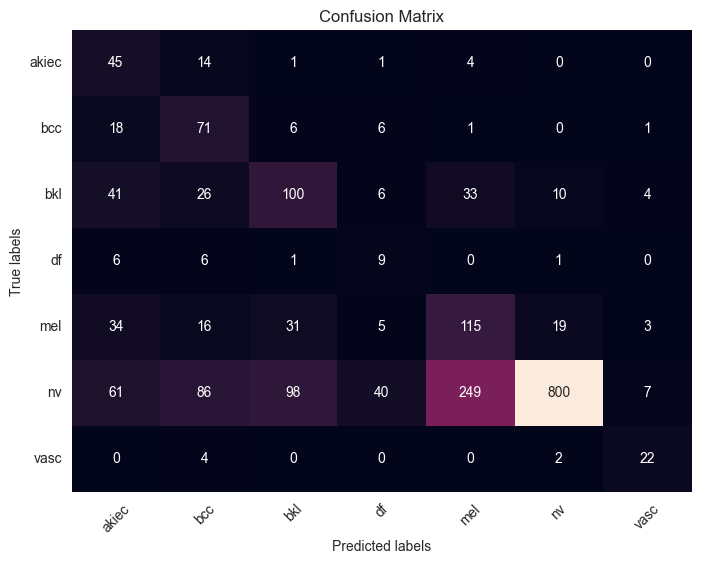

              precision    recall  f1-score   support

           0       0.22      0.69      0.33        65
           1       0.32      0.69      0.44       103
           2       0.42      0.45      0.44       220
           3       0.13      0.39      0.20        23
           4       0.29      0.52      0.37       223
           5       0.96      0.60      0.74      1341
           6       0.59      0.79      0.68        28

    accuracy                           0.58      2003
   macro avg       0.42      0.59      0.46      2003
weighted avg       0.76      0.58      0.63      2003


In [68]:
evaluation_metrics(model_1e, test_data, y_test, class_names)

In [65]:
model_1f = tf.keras.models.clone_model(model_1a)

In [66]:
model_1f.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_1f = model_1f.fit(train_data, epochs=100,
                        validation_data=test_data)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 42s 173ms/step - accuracy: 0.1968 - loss: 1.8837 - val_accuracy: 0.4703 - val_loss: 1.3635
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 174ms/step - accuracy: 0.3149 - loss: 1.6598 - val_accuracy: 0.4673 - val_loss: 1.2524
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 171ms/step - accuracy: 0.4222 - loss: 1.3940 - val_accuracy: 0.4314 - val_loss: 1.3298
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - accuracy: 0.4559 - loss: 1.3180 - val_accuracy: 0.4963 - val_loss: 1.3277
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 164ms/step - accuracy: 0.4561 - loss: 1.3304 - val_accuracy: 0.5297 - val_loss: 1.1827
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.4991 - loss: 1.2459 - val_accuracy: 0.5147 - val_loss: 1.1642
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 175ms/step - accuracy: 0.5017 - loss: 1.2049 - val_accuracy: 0.3899 - val_loss: 1.4284
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 40s 178ms/step - accuracy: 0.4909 -

KeyboardInterrupt: 

In [ ]:
plot_loss_accuracy_curves(history_1f)

In [ ]:
evaluation_metrics(model_1f, train_data, y_test, class_names)

In [23]:
model_2c = Sequential([
    BatchNormalization(),
    Conv2D(filters=32,
            kernel_size=3,
            activation="relu",
            input_shape=(128, 128, 3),
            padding="same"),
    Conv2D(32, 3, activation="relu", padding="same"),
    MaxPool2D(pool_size=2, padding="valid"),
    Conv2D(64, 3, activation="relu", padding="same"),
    Conv2D(64, 3, activation="relu", padding="same"),
    MaxPool2D(2),
    Conv2D(128, 3, activation="relu", padding="same"),
    Conv2D(128, 3, activation="relu", padding="same"),
    Conv2D(128, 3, activation="relu", padding="same"),
    MaxPool2D(2),
    Conv2D(256, 3, activation="relu", padding="same"),
    Conv2D(256, 3, activation="relu", padding="same"),
    Conv2D(256, 3, activation="relu", padding="same"),
    MaxPool2D(2),
    Dropout(0.3),
    BatchNormalization(),
    Conv2D(512, 3, activation="relu", padding="same"),
    Conv2D(512, 3, activation="relu", padding="same"),
    Conv2D(512, 3, activation="relu", padding="same"),
    Flatten(),
    Dropout(0.3),
    Dense(1024, activation="relu"),
    Dropout(0.3),
    Dense(256, activation="relu"),
    Dense(7, activation="softmax")
])


In [23]:
model_2c.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_2c = model_2c.fit(train_data, epochs=20,
                        validation_data=test_data)

Epoch 1/20


C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 527s 2s/step - accuracy: 0.1535 - loss: 2.2697 - val_accuracy: 0.1113 - val_loss: 1.9441
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 604s 3s/step - accuracy: 0.1336 - loss: 1.9464 - val_accuracy: 0.1113 - val_loss: 1.9513
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 878s 4s/step - accuracy: 0.1432 - loss: 1.9461 - val_accuracy: 0.1113 - val_loss: 1.9491
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 524s 2s/step - accuracy: 0.1396 - loss: 1.9461 - val_accuracy: 0.1113 - val_loss: 1.9470
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 530s 2s/step - accuracy: 0.1388 - loss: 1.9460 - val_accuracy: 0.0325 - val_loss: 1.9456
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.1487 - loss: 1.9459 - val_accuracy: 0.0115 - val_loss: 1.9467
Epoch 7/20
  9/219 ━━━━━━━━━━━━━━━━━━━━ 13:02 4s/step - accuracy: 0.1570 - loss: 1.9456

In [23]:
model_1g = Sequential([
    Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(128, 128, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2, padding="valid"),
    Conv2D(32, 3, activation="relu"),
    Conv2D(32, 3, activation="relu"),
    MaxPool2D(2),
    Conv2D(64,3,activation="relu"),
    Conv2D(64,3,activation="relu"),
    Conv2D(64,3,activation="relu"),
    MaxPool2D(2),
    Conv2D(128,3,activation="relu"),
    Conv2D(128,3,activation="relu"),
    Conv2D(128,3,activation="relu"),
    Flatten(),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),  
    Dense(7, activation="softmax")
])

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [24]:
model_1g.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_1g = model_1g.fit(train_data, epochs=100,
                        validation_data=test_data)

Epoch 1/100


C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 72s 305ms/step - accuracy: 0.1434 - loss: 1.9503 - val_accuracy: 0.1113 - val_loss: 1.9414
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 65s 293ms/step - accuracy: 0.1415 - loss: 1.9464 - val_accuracy: 0.0140 - val_loss: 1.9553
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 331ms/step - accuracy: 0.1425 - loss: 1.9462 - val_accuracy: 0.0325 - val_loss: 1.9471
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 129s 584ms/step - accuracy: 0.1373 - loss: 1.9461 - val_accuracy: 0.0325 - val_loss: 1.9436
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 111s 498ms/step - accuracy: 0.1328 - loss: 1.9461 - val_accuracy: 0.0325 - val_loss: 1.9461
Epoch 6/100
  6/219 ━━━━━━━━━━━━━━━━━━━━ 1:11 335ms/step - accuracy: 0.0606 - loss: 1.9465

KeyboardInterrupt: 

In [25]:
model_3 = Sequential([
    Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(128, 128, 3)),
    BatchNormalization(),
    Conv2D(32, 3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, padding="valid"),

    Conv2D(64, 3, activation="relu"),
    BatchNormalization(),
    Conv2D(64, 3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(2),

    Conv2D(128, 3, activation="relu"),
    BatchNormalization(),
    Conv2D(128, 3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(2),

    Flatten(),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dense(7, activation="softmax")
])

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [26]:
model_3.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_3 = model_3.fit(train_data, epochs=15,
                        validation_data=test_data)

Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.3846 - loss: 1.8837 - val_accuracy: 0.0514 - val_loss: 4.9654
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - accuracy: 0.5237 - loss: 1.2379 - val_accuracy: 0.0944 - val_loss: 5.0934
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.5667 - loss: 1.1431 - val_accuracy: 0.4598 - val_loss: 1.4378
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.6011 - loss: 1.0600 - val_accuracy: 0.5597 - val_loss: 1.3604
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.6253 - loss: 0.9961 - val_accuracy: 0.4528 - val_loss: 1.8185
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.6581 - loss: 0.9284 - val_accuracy: 0.4378 - val_loss: 1.5360
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.6828 - loss: 0.8587 - val_accuracy: 0.6026 - val_loss: 1.0674
Epoch 8/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.6858 - loss: 0.8337 - val_accu

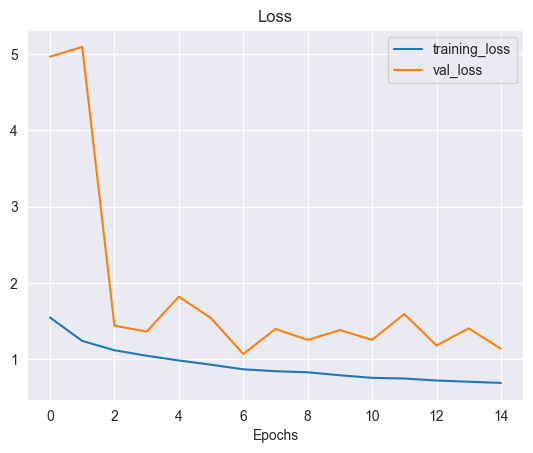

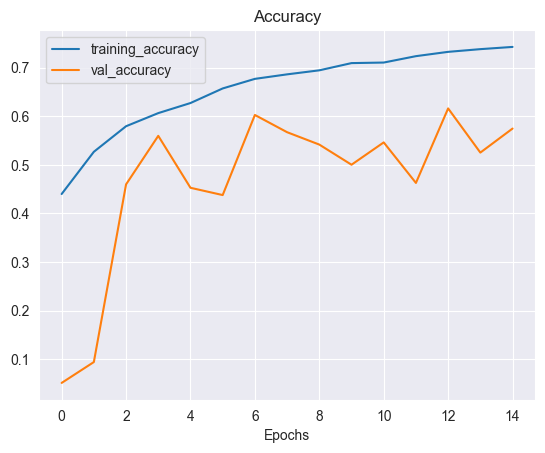

In [32]:
plot_loss_accuracy_curves(history_3)

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step


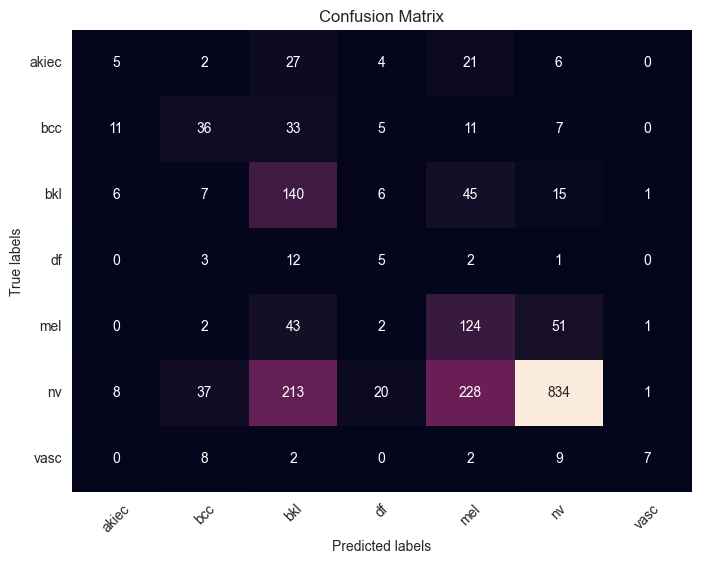

              precision    recall  f1-score   support

       akiec       0.17      0.08      0.11        65
         bcc       0.38      0.35      0.36       103
         bkl       0.30      0.64      0.41       220
          df       0.12      0.22      0.15        23
         mel       0.29      0.56      0.38       223
          nv       0.90      0.62      0.74      1341
        vasc       0.70      0.25      0.37        28

    accuracy                           0.57      2003
   macro avg       0.41      0.39      0.36      2003
weighted avg       0.71      0.57      0.61      2003


In [33]:
evaluation_metrics(model_3, test_data, y_test, class_names)

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from kerastuner import HyperModel

class CNNHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()

        # First Conv2D Layer
        model.add(Conv2D(
            filters=hp.Choice('filters_1', values=[10, 16, 32, 64]),
            kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
            activation='relu',
            input_shape=(128, 128, 3)))
        model.add(MaxPool2D(pool_size=2))

        # Additional Conv2D Layers with fixed kernel_size and batch normalization option
        for i in range(hp.Int('num_conv_layers', 1, 5)):
            model.add(Conv2D(
                filters=hp.Choice(f'filters_{i+2}', values=[32, 64, 128]),
                kernel_size=3,
                activation='relu',
                padding='same'))
            model.add(Conv2D(
                filters=hp.Choice(f'filters_{i+2}', values=[32, 64, 128]),
                kernel_size=3,
                activation='relu',
                padding='same'))
            if hp.Boolean(f'batch_norm_{i+2}'):
                model.add(BatchNormalization())
            model.add(MaxPool2D(pool_size=2))

        # Flatten layer
        model.add(Flatten())

        # Dense layer
        model.add(Dense(
            units=hp.Choice('dense_units', values=[256, 512]),
            activation='relu'))
        if hp.Boolean('dropout'):
            model.add(Dropout(rate=0.5))

        # Output layer
        model.add(Dense(7, activation='softmax'))

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Choice('learning_rate', values=[1e-3, 1e-4])),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

        return model


In [35]:
hypermodel = CNNHyperModel()

In [36]:
tuner = kt.RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10, 
    executions_per_trial=2)

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [37]:
tuner.search(train_data, epochs=10, validation_data=test_data)

Trial 10 Complete [00h 01m 59s]

Best val_loss So Far: 0.8534301221370697
Total elapsed time: 09h 17m 28s


In [38]:
best_model = tuner.get_best_models()[0]

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [46]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 31, 31, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 31, 31, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,774,343 (14.40 MB)

 Trainable params: 3,774,087 (14.40 MB)

 Non-trainable params: 256 (1.00 KB)

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 478ms/step


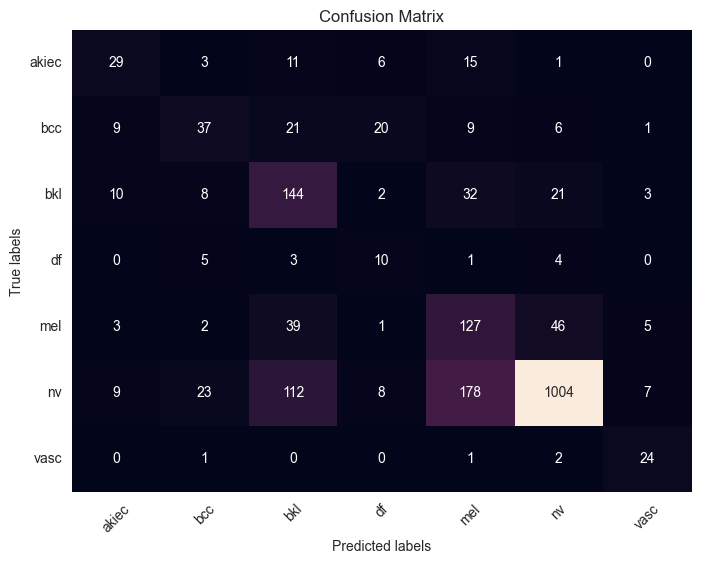

              precision    recall  f1-score   support

       akiec       0.48      0.45      0.46        65
         bcc       0.47      0.36      0.41       103
         bkl       0.44      0.65      0.52       220
          df       0.21      0.43      0.29        23
         mel       0.35      0.57      0.43       223
          nv       0.93      0.75      0.83      1341
        vasc       0.60      0.86      0.71        28

    accuracy                           0.69      2003
   macro avg       0.50      0.58      0.52      2003
weighted avg       0.76      0.69      0.71      2003


In [47]:
evaluation_metrics(best_model, test_data, y_test, class_names)

In [49]:
best_model.save("CNN_best.keras")